In [11]:
import torch
from torch import nn
from torch.utils.data import Dataset
import string
import os
import unicodedata
import io
import os
import unicodedata
import string
import glob
import random

In [12]:
# data prep
all_letters = string.ascii_letters + ".,;'"
n_letters = len(all_letters)

def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def load_data():
    # Build the category_lines dictionary, a list of names per language
    category_lines = {}
    all_categories = []
    
    def find_files(path):
        return glob.glob(path)
    
    # Read a file and split into lines
    def read_lines(filename):
        lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
        return [unicode_to_ascii(line) for line in lines]
    
    for filename in find_files('data/names/*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)
        
        lines = read_lines(filename)
        category_lines[category] = lines
        
    return category_lines, all_categories

# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor

In [33]:
def random_training_example(category_lines, all_categories):
    
    def random_choice(a):
        random_idx = random.randint(0, len(a) - 1)
        return a[random_idx]
    
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor


In [34]:
# declaration


In [41]:
class NameClassify(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_to_hidden = nn.Linear(input_size+hidden_size,hidden_size)
        self.input_to_output = nn.Linear(input_size+hidden_size,output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self,x_tensor,hidden_tensor):
        combined = torch.cat((x_tensor,hidden_tensor),1)

        hidden = self.input_to_hidden(combined)
        output = self.input_to_output(combined)
        output = self.softmax(output)

        return output,hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [42]:
category_lines,all_categories = load_data()
n_categories = len(all_categories)

In [43]:
n_hidden = 128

rnn = NameClassify(n_letters,n_hidden,n_categories)

def category_from_output(output):
    idx = torch.argmax(output).item()
    return all_categories[idx]

In [44]:
loss_fn = nn.NLLLoss()
lr = 0.005
optim = torch.optim.SGD(rnn.parameters(),lr=lr)

In [51]:
def train(input_tensor,category_tensor):
    hidden = rnn.init_hidden()

    for i in range(input_tensor.size()[0]):
        output, hidden = rnn(input_tensor[i],hidden)

    loss = loss_fn(output,category_tensor)

    optim.zero_grad()
    loss.backward()
    optim.step()

    return output,loss.item()

In [52]:
current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_epoch = 100000

for epoch in range(n_epoch):
    label,inp,label_tensor,input_tensor = random_training_example(category_lines,all_categories)
    output,loss = train(input_tensor,label_tensor)
    current_loss += loss

    if (epoch+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0
        
    if (epoch+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == label else f"WRONG ({label})"
        print(f"{epoch+1} {(epoch+1)/n_epoch*100} {loss:.4f} {inp} / {guess} {correct}")

5000 5.0 3.1262 Baik / Spanish WRONG (Korean)
10000 10.0 2.7425 Specht / Portuguese WRONG (Dutch)
15000 15.0 2.5802 Slaski / Italian WRONG (Polish)
20000 20.0 2.5067 Vilaro / Portuguese WRONG (Spanish)
25000 25.0 2.8018 Maas / Greek WRONG (Dutch)
30000 30.0 3.0252 Lim / Spanish WRONG (Korean)
35000 35.0 2.6931 Johnston / Russian WRONG (Scottish)
40000 40.0 2.9918 Thai / Italian WRONG (Vietnamese)
45000 45.0 3.0293 Kwang / Chinese WRONG (Korean)
50000 50.0 2.7845 Kerr / German WRONG (Scottish)
55000 55.00000000000001 2.2569 Bakhlaev / Russian CORRECT
60000 60.0 2.7071 Maclean / Dutch WRONG (Scottish)
65000 65.0 2.2483 Talagaev / Russian CORRECT
70000 70.0 2.6329 Ventura / Spanish WRONG (Portuguese)
75000 75.0 2.5139 Koolen / Dutch CORRECT
80000 80.0 2.8262 Wallace / Italian WRONG (Scottish)
85000 85.0 2.3294 Aliberti / Italian CORRECT
90000 90.0 2.7911 Cassidy / Russian WRONG (Irish)
95000 95.0 2.4755 Abello / Spanish CORRECT
100000 100.0 3.0511 Phi / Italian WRONG (Vietnamese)


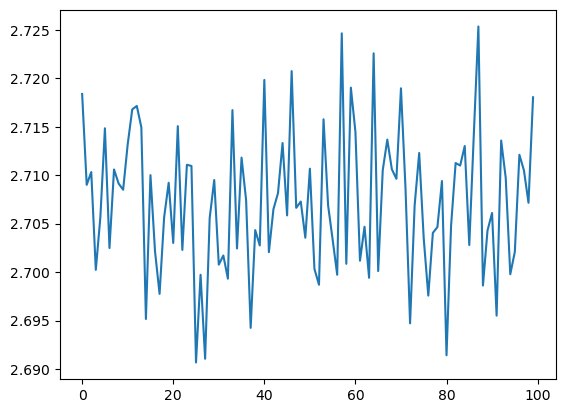

In [53]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)
plt.show()

In [48]:

class RNN(nn.Module):
    # implement RNN from scratch rather than using nn.RNN
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)
    
category_lines, all_categories = load_data()
n_categories = len(all_categories)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

# one step
input_tensor = letter_to_tensor('A')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor, hidden_tensor)
#print(output.size())
#print(next_hidden.size())

# whole sequence/name
input_tensor = line_to_tensor('Albert')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor[0], hidden_tensor)
#print(output.size())
#print(next_hidden.size())

#
def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

print(category_from_output(output))

criterion = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

def train(line_tensor, category_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000
for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)
    
    output, loss = train(line_tensor, category_tensor)
    current_loss += loss 
    
    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0
        
    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{i+1} {(i+1)/n_iters*100} {loss:.4f} {line} / {guess} {correct}")
        
    
plt.figure()
plt.plot(all_losses)
plt.show()

def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        
        hidden = rnn.init_hidden()
    
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        
        guess = category_from_output(output)
        print(guess)


while True:
    sentence = input("Input:")
    if sentence == "quit":
        break
    
    predict(sentence)
    

Arabic


KeyboardInterrupt: 